Este notebook tiene la finalidad de realizar la carga, transformación y un posterior análisis (ETL + EDA) de los datasets del sitio Google Maps.

In [1]:
# Importamos las librerias a utilizar
import pandas as pd
import numpy as np
import os
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime

In [144]:
sns.color_palette("pastel")

[(0.6313725490196078, 0.788235294117647, 0.9568627450980393),
 (1.0, 0.7058823529411765, 0.5098039215686274),
 (0.5529411764705883, 0.8980392156862745, 0.6313725490196078),
 (1.0, 0.6235294117647059, 0.6078431372549019),
 (0.8156862745098039, 0.7333333333333333, 1.0),
 (0.8705882352941177, 0.7333333333333333, 0.6078431372549019),
 (0.9803921568627451, 0.6901960784313725, 0.8941176470588236),
 (0.8117647058823529, 0.8117647058823529, 0.8117647058823529),
 (1.0, 0.996078431372549, 0.6392156862745098),
 (0.7254901960784313, 0.9490196078431372, 0.9411764705882353)]

In [145]:
sns.set_palette("pastel")

review-estados

In [241]:
# Lee el archivo JSON y carga los datos en un DataFrame de pandas
df = pd.read_json("Datasets/Google Maps/review-estados/review-Alabama/11.json", lines = True)

c:\Users\Mauricio Figueroa\.virtualenvs\Python-env--sma9hmZ\Lib\site-packages\pandas\core\dtypes\astype.py:189: RuntimeWarning: invalid value encountered in cast
  return values.astype(dtype, copy=copy)


In [7]:
# Cada archivo tiene aproximadamente 150 mil registros
len(df)

150000

In [23]:
# La información de cada review esta contenida en las siguientes columnas
df.columns

Index(['user_id', 'name', 'time', 'rating', 'text', 'pics', 'resp', 'gmap_id'], dtype='object')

In [30]:
# Vemos que hay algunos registros (pocos) donde el comercio hace una devolución. Consideramos importante esta devolución
df[~df["resp"].isna()]

,user_id,name,time,rating,text,pics,resp,gmap_id
60,1.019555e+20,MrNiceGuy420,1620252981528,5,"It's quiet , cameras everywhere and a hardee's...",None,"{'time': 1620253626918, 'text': 'Thank you for...",0x88882af73c1dd91f:0x399a5e0c64165330
73,1.061407e+20,Kenneth Smith,1573595680762,5,Awesome and safe place to do your laundry.clea...,None,"{'time': 1573836762445, 'text': 'Thank you! We...",0x88882af73c1dd91f:0x399a5e0c64165330
77,1.183360e+20,Brandy Gipson,1576542079720,5,Its very clean and the washing machines and dr...,None,"{'time': 1576608216452, 'text': 'Thank you Bra...",0x88882af73c1dd91f:0x399a5e0c64165330
97,1.107800e+20,Damien Long,1617727974641,4,👍🏼,None,"{'time': 1617732842952, 'text': 'Thank you for...",0x88882af73c1dd91f:0x399a5e0c64165330
103,1.145796e+20,Kelly Ballam,1616568755311,5,None,None,"{'time': 1617732881857, 'text': 'Thank you for...",0x88882af73c1dd91f:0x399a5e0c64165330
...,...,...,...,...,...,...,...,...
149919,1.086057e+20,Samantha Vines,1556313173819,5,None,None,"{'time': 1556826886268, 'text': 'Thanks so muc...",0x8889cbb390b6d7ab:0x62b42d79d9d55109
149920,1.046784e+20,Carolyn Pearl,1544271470421,5,None,None,"{'time': 1544480389291, 'text': 'Thanks Caroly...",0x8889cbb390b6d7ab:0x62b42d79d9d55109
149921,1.005816e+20,Madison Espy,1527015204203,5,None,None,"{'time': 1527106474830, 'text': 'Thanks-a-mill...",0x8889cbb390b6d7ab:0x62b42d79d9d55109
149926,1.145077e+20,Dale Blakely,1562189862455,5,None,None,"{'time': 1563993083330, 'text': 'Thanks so muc...",0x8889cbb390b6d7ab:0x62b42d79d9d55109


Hacemos una función genérica para recorrer todos los archivos de cada estado y formar un solo DataFrame con la info relevante

In [2]:
def cargar_archivos_json(ruta_base, ruta_destino):

    # Diccionario para llevar el conteo de reviews nulas (review o devolución) por estado
    conteo_nulos = {}
    cantidad_duplicados = 0

    # Recorre todas las carpetas dentro de la ruta_base
    for estado_folder in os.listdir(ruta_base):

        # Lista para almacenar los df que corresponden a cada json
        lista_dataframes = []

        estado_path = os.path.join(ruta_base, estado_folder)

        # Variable para guardar el nombre del estado
        estado_string = estado_folder.replace("review-", "")
        
        # Inicializa el conteo de nulos para el estado actual
        conteo_nulos[estado_string] = 0

        # Verifica si es una carpeta
        if os.path.isdir(estado_path):
            # Recorre todos los archivos JSON dentro de la carpeta del estado
            for json_file in os.listdir(estado_path):
                if json_file.endswith('.json'):
                    json_path = os.path.join(estado_path, json_file)

                    # Lee el archivo JSON y carga los datos en un DataFrame
                    df = pd.read_json(json_path, lines = True)

                    # Elimina duplicados
                    tamaño_original = len(df)
                    df = df.astype(str).drop_duplicates()
                    # Calcula la cantidad de duplicados eliminados
                    cantidad_duplicados += tamaño_original - len(df)

                    df["time"] = df["time"].astype(np.int64)
                    # Convertimos el tiempo a tipo de dato datetime
                    df["time"] = [datetime.utcfromtimestamp(unix_time/1000).strftime('%Y-%m-%d') for unix_time in df["time"]]

                    # Incrementa el conteo de nulos si "text" o "resp" son NaN
                    conteo_nulos[estado_string] += df[["text", "resp"]].isna().all(axis=1).sum()

                    # Limpiamos los nan en la columna de reviews en caso de que la review o la respuesta sean NaN
                    df = df.dropna(subset = ["text", "resp"], how = "all")

                    # Dejamos las columnas que nos interesan
                    df = df[["time", "rating", "text", "resp", "gmap_id"]]

                    # Agrega el DataFrame a la lista
                    lista_dataframes.append(df)

        # Concatena los dataFrames en uno solo
        review_estado = pd.concat(lista_dataframes, ignore_index = True)

        # Exporta reviews_estado a un archivo CSV
        csv_path = os.path.join(ruta_destino, f"review-{estado_string}.csv")
        review_estado.to_csv(csv_path, index=False)

    return conteo_nulos, cantidad_duplicados

In [ ]:
# Ruta base donde se encuentran las carpetas "review-estados"
ruta_base = "Datasets/Google Maps/review-estados"
ruta_destino = "Datasets/Google Maps/review-estados-clean"

# Llama a la función y almacena el conteo de nulos
conteo_nulos, cantidad_duplicados = cargar_archivos_json(ruta_base, ruta_destino)

In [11]:
# Muestra el conteo de nulos por estado, si las columnas text y resp eran nulas
for estado, conteo in conteo_nulos.items():
    print(f"Estado: {estado}, Registros Nulos: {conteo}")

Estado: Alabama, Registros Nulos: 760061
Estado: Alaska, Registros Nulos: 208566
Estado: Arizona, Registros Nulos: 632210
Estado: Arkansas, Registros Nulos: 1011648
Estado: California, Registros Nulos: 1093815
Estado: Colorado, Registros Nulos: 807096
Estado: Connecticut, Registros Nulos: 187694
Estado: Delaware, Registros Nulos: 373253
Estado: District_of_Columbia, Registros Nulos: 255029
Estado: Florida, Registros Nulos: 957433
Estado: Georgia, Registros Nulos: 715159
Estado: Hawaii, Registros Nulos: 615152
Estado: Idaho, Registros Nulos: 795796
Estado: Illinois, Registros Nulos: 829685
Estado: Indiana, Registros Nulos: 912398
Estado: Iowa, Registros Nulos: 1190817
Estado: Kansas, Registros Nulos: 813840
Estado: Kentucky, Registros Nulos: 686014
Estado: Louisiana, Registros Nulos: 651816
Estado: Maine, Registros Nulos: 476105
Estado: Maryland, Registros Nulos: 972803
Estado: Massachusetts, Registros Nulos: 1052584
Estado: Michigan, Registros Nulos: 850459
Estado: Minnesota, Registros

In [18]:
# Registros nulos total
print(f"Registros Nulos total: {sum(conteo_nulos.values())}")

Registros Nulos total: 34613269


In [227]:
print(f"Cantidad de duplicados total: {cantidad_duplicados}")

Cantidad de duplicados total: 1576027


metadata-sitios

In [79]:
# Lee el archivo JSON y carga los datos en un DataFrame de pandas
df = pd.read_json("Datasets/Google Maps/metadata-sitios/1.json", lines = True)

In [12]:
# Leemos un archivo con los estados de USA y abreviaturas
states = pd.read_csv("Datasets/states.csv")

In [6]:
df.head(2)

,name,address,gmap_id,description,latitude,longitude,category,avg_rating,num_of_reviews,price,hours,MISC,state,relative_results,url
0,Porter Pharmacy,"Porter Pharmacy, 129 N Second St, Cochran, GA ...",0x88f16e41928ff687:0x883dad4fd048e8f8,None,32.388300,-83.35710,[Pharmacy],4.9,16,None,"[[Friday, 8AM–6PM], [Saturday, 8AM–12PM], [Sun...","{'Service options': ['In-store shopping', 'Sam...",Open ⋅ Closes 6PM,"[0x88f16e41929435cf:0x5b2532a2885e9ef6, 0x88f1...",https://www.google.com/maps/place//data=!4m2!3...
1,City Textile,"City Textile, 3001 E Pico Blvd, Los Angeles, C...",0x80c2c98c0e3c16fd:0x29ec8a728764fdf9,None,34.018891,-118.21529,[Textile exporter],4.5,6,None,None,None,Open now,"[0x80c2c624136ea88b:0xb0315367ed448771, 0x80c2...",https://www.google.com/maps/place//data=!4m2!3...


In [45]:
df.iloc[12592]["address"]            # 1262 3506 4133 12592 18572 19482

'Barber King - Hair cut, Straight shave and Unlimited Haircut for Kids,Adults and Seniors, 5349 Antoine Dr, Houston, TX 77091'

In [8]:
# Resumen de las features disponibles
df.columns

Index(['name', 'address', 'gmap_id', 'description', 'latitude', 'longitude',
       'category', 'avg_rating', 'num_of_reviews', 'price', 'hours', 'MISC',
       'state', 'relative_results', 'url'],
      dtype='object')

In [14]:
# Tamaño del dataframe
df.shape

(275001, 15)

In [13]:
# Hay valores nulos?
df.isna().sum()

name                     7
address              10062
gmap_id                  0
description         261846
latitude                 0
longitude                0
category              2261
avg_rating               0
num_of_reviews           0
price               261551
hours                82553
MISC                 80029
state                79478
relative_results     36230
url                      0
dtype: int64

Hay features que en su mayoría tienen NaN por lo que no aportan a una estadística o sistema de recomendación ("description" y "price"). Vamos a analizar las demás.

In [12]:
df.head()["address"].values

array(['Porter Pharmacy, 129 N Second St, Cochran, GA 31014',
       'City Textile, 3001 E Pico Blvd, Los Angeles, CA 90023',
       'San Soo Dang, 761 S Vermont Ave, Los Angeles, CA 90005',
       'Nova Fabrics, 2200 E 11th St, Los Angeles, CA 90021',
       'Nobel Textile Co, 719 E 9th St, Los Angeles, CA 90021'],
      dtype=object)

La columna "address" contiene valores separados por coma, vamos a tener que separar la info.
Se ve primero el nombre del comercio, luego dirección, ciudad y ZIP Code (state + 5 digitos) 

In [41]:
df.astype(str).duplicated().sum()

26573

Tenemos 26573 registros duplicados, debemos limpiarlos 

In [22]:
df.head(10)["category"]

0                                     [Pharmacy]
1                             [Textile exporter]
2                            [Korean restaurant]
3                                 [Fabric store]
4                                 [Fabric store]
5                                 [Fabric store]
6                                   [Restaurant]
7      [Nail salon, Waxing hair removal service]
8               [Bakery, Health food restaurant]
9    [Greeting card shop, Service establishment]
Name: category, dtype: object

In [21]:
df["category"].explode().nunique()

3769

La columna categoría es multilabel

In [15]:
df.head()["state"]

0    Open ⋅ Closes 6PM
1             Open now
2    Open ⋅ Closes 6PM
3    Open ⋅ Closes 5PM
4    Open ⋅ Closes 5PM
Name: state, dtype: object

La columna state no nos sirve, es un valor instantaneo sobre si el comercio está abierto o no.

In [25]:
df.head(1)["relative_results"].values

array([list(['0x88f16e41929435cf:0x5b2532a2885e9ef6', '0x88f16c32716531c1:0x5f19bdaa5044e4fa', '0x88f16e6e3f4a21df:0xcf495da9bb4d89ea'])],
      dtype=object)

Queda por ver si los relative results son comercios asociados. En este dataset no lo encontramos, deberíamos unirlos todos

Ahora pasamos a hacer una función que procese todos los json de manera automática

In [65]:
valores_aux.str.get(0)

0         GA
1         CA
2         CA
3         CA
4         CA
          ..
274996    SC
274997    SC
274998    SC
274999    MI
275000    MI
Name: address, Length: 275001, dtype: object

In [74]:
aux_df

0         [Porter Pharmacy, 129 N Second St, Cochran, GA...
1         [City Textile, 3001 E Pico Blvd, Los Angeles, ...
2         [San Soo Dang, 761 S Vermont Ave, Los Angeles,...
3         [Nova Fabrics, 2200 E 11th St, Los Angeles, CA...
4         [Nobel Textile Co, 719 E 9th St, Los Angeles, ...
                                ...                        
274996    [Maven Realty, 2180 McMillan Ave #71672, North...
274997    [Stone Castle Fence, 124 Cypress Gardens Rd, M...
274998    [Health Insurance Solutions Team, 6650 Rivers ...
274999    [Bernard Building Center, 27300 M-32, M-32, Hi...
275000       [HMR Motor Works and Auto Care, Mio, MI 48647]
Name: address, Length: 275001, dtype: object

In [80]:
aux_df = df["address"].str.split(', ')

In [82]:
def aplicar_condicion(lista):
    if isinstance(lista, list):
        if len(lista) == 2 and lista[0] in states["State"].values or lista[0] in states["Abbreviation"].values:
            return True
        else:
            return False
    else:
        return False

# Primera condicion, que este dentro de los estados o sus abreviaturas
valores_aux = aux_df.apply(lambda x: x[-1] if isinstance(x, list) else None)
valores_aux = valores_aux.str.split()
condicion = valores_aux.apply(aplicar_condicion)
df.loc[condicion, "state"] = valores_aux[condicion].str.get(0)
df.loc[condicion, "zip code"] = valores_aux[condicion].str.get(1)

# Verificamos para aquellos state zip donde aparezca solo el state
condicion_2 = valores_aux.apply(lambda x: x in states["State"].values or x in states["Abbreviation"].values)
df.loc[condicion_2, "state"] = valores_aux[condicion_2].str.get(0)

# Unificamos los registros donde procesamos las condiciones en uno, para cargar mas informacion
condicion = condicion + condicion_2

C:\Users\Mauricio Figueroa\AppData\Local\Temp\ipykernel_20444\3182278735.py:18: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condicion_2 = valores_aux.apply(lambda x: x in states["State"].values or x in states["Abbreviation"].values)


In [116]:
valores_aux

0         [GA, 31014]
1         [CA, 90023]
2         [CA, 90005]
3         [CA, 90021]
4         [CA, 90021]
             ...     
274996    [SC, 29405]
274997    [SC, 29461]
274998    [SC, 29406]
274999    [MI, 49746]
275000    [MI, 48647]
Name: address, Length: 275001, dtype: object

In [114]:
condicion_2 = valores_aux.isin(states["State"].values) | valores_aux.isin(states["Abbreviation"].values)

In [117]:
condicion_2.sum()

0

In [99]:
aux_df[condicion_2]

42                           [Knight Hawk, Lyons, KS 67554]
44           [State Street/7th Street, El Centro, CA 92243]
46             [Burnette Baptist Church, Detroit, MI 48227]
78        [Vancouver (99th St Station), Vancouver, WA 98...
160       [Bixler Lake Disc Golf Course - East, Kendallv...
                                ...                        
274911                        [Happy Nail, Cairo, GA 39828]
274920                  [Zion Hill Church, Cairo, GA 39828]
274942             [Market & Pine NW, Long Beach, CA 90805]
274980           [Little Free Library, Iowa City, IA 52240]
275000       [HMR Motor Works and Auto Care, Mio, MI 48647]
Name: address, Length: 9815, dtype: object

In [96]:
aux_df.loc[condicion_2].apply(lambda x: x[-3])

0                  129 N Second St
1                 3001 E Pico Blvd
2                761 S Vermont Ave
3                   2200 E 11th St
4                     719 E 9th St
                    ...           
274993               2620 N 5th St
274996    2180 McMillan Ave #71672
274997      124 Cypress Gardens Rd
274998             6650 Rivers Ave
274999                        M-32
Name: address, Length: 249242, dtype: object

In [133]:
# Función para ejecutar los cambios vistos y unir los datasets de metadata-sitios

def cargar_archivos_json_2(ruta_base):

    # Variables para llevar el conteo de registros y nulos

    conteo_registros = 0
    conteo_duplicados = 0

    # Lista para almacenar los df que corresponden a cada json
    lista_dataframes = []

    def aplicar_condicion(lista):       # Estas dos funciones son para aportar al procesamiento de la columna "address"
        if isinstance(lista, list):
            if len(lista) == 2 and lista[0] in states["State"].values or lista[0] in states["Abbreviation"].values:
                return True
            else:
                return False
        else:
            return False
        
    def aplicar_condicion_2(lista):
        if isinstance(lista, list):
            if len(lista) == 1 and lista[0] in states["State"].values or lista[0] in states["Abbreviation"].values:
                return True
            else:
                return False
        else:
            return False

    # Recorre todas las carpetas dentro de la ruta_base
    for json_file in os.listdir(ruta_base):

        if json_file.endswith('.json'):
            json_path = os.path.join(ruta_base, json_file)

            # Lee el archivo JSON y carga los datos en un DataFrame
            df = pd.read_json(json_path, lines = True)

            # Borramos las columnas "description", "price" y "state"
            df = df.drop(columns = ["description", "price", "state"])

            # Hacemos el conteo de registros
            conteo_registros += df.shape[0]
            conteo_duplicados += df.astype(str).duplicated().sum()

            # Borramos registros duplicados
            df = df.astype(str).drop_duplicates()

            # Hacemos la transformación de la columna "address"
            # Vamos a crear nuevas columnas separando el contenido (la primer columna es el "name" del lugar, no lo necesitamos)

            aux_df = df["address"].str.split(', ')

            # Primera condicion, que este dentro de los estados o sus abreviaturas
            valores_aux = aux_df.apply(lambda x: x[-1] if isinstance(x, list) else None)
            valores_aux = valores_aux.str.split()
            condicion = valores_aux.apply(aplicar_condicion)
            df.loc[condicion, "state"] = valores_aux[condicion].str.get(0)
            df.loc[condicion, "zip code"] = valores_aux[condicion].str.get(1)
            
            # Verificamos para aquellos state zip donde aparezca solo el state
            condicion_2 = valores_aux.apply(aplicar_condicion_2)
            df.loc[condicion_2, "state"] = valores_aux[condicion_2].str.get(0)

            df["state"] = df["state"].map(states.set_index("Abbreviation")["State"])

            # Unificamos los indexers donde procesamos los estados anteriormente para cargar mas informacion
            condicion = condicion + condicion_2

            # Para listas de cuatro o cinco, que son la gran mayoria de casos
            condicion_2 = condicion & aux_df[condicion].apply(lambda x: isinstance(x, list) and len(x) in [4, 5])
            df.loc[condicion_2, "address"] = aux_df.loc[condicion_2].apply(lambda x: x[-3])
            df.loc[condicion_2, "city"] = aux_df.loc[condicion_2].apply(lambda x: x[-2])

            # Para listas de tres
            condicion_2 = condicion & aux_df[condicion].apply(lambda x: isinstance(x, list) and len(x) == 3)
            df.loc[condicion_2, "address"] = None
            df.loc[condicion_2, "city"] = aux_df.loc[condicion_2].apply(lambda x: x[-2])

            # Anexamos los dataframes
            lista_dataframes.append(df)
    
    # Concatena los dataFrames en uno solo
    metadata_sitios = pd.concat(lista_dataframes, ignore_index = True)

    return metadata_sitios, conteo_registros, conteo_duplicados

In [134]:
# Ruta base donde se encuentran las carpetas "review-estados"
ruta_base = "Datasets/Google Maps/metadata-sitios"

# Llama a la función y almacena el conteo de nulos
metadata_sitios, conteo_registros, conteo_duplicados = cargar_archivos_json_2(ruta_base)

In [131]:
metadata_sitios["state"].value_counts()

California              24071
Texas                   21009
Florida                 17012
New York                13497
Pennsylvania             9714
Illinois                 8855
Ohio                     8035
North Carolina           7916
Georgia                  7663
Michigan                 7349
New Jersey               6395
Washington               5752
Virginia                 5561
Tennessee                5175
Colorado                 4818
Missouri                 4748
Massachusetts            4713
Indiana                  4684
Arizona                  4668
Wisconsin                4304
Minnesota                4078
Alabama                  3924
South Carolina           3854
Maryland                 3844
Oregon                   3499
Louisiana                3172
Oklahoma                 3107
Kentucky                 3044
Iowa                     2586
Connecticut              2489
Utah                     2453
Arkansas                 2334
Kansas                   2296
Nevada    

In [135]:
metadata_sitios.shape

(2998438, 15)

In [136]:
# Registros totales y nulos:
print(f"Registros totales: {conteo_registros}")
print(f"Registros duplicados: {conteo_duplicados}")

Registros totales: 3025011
Registros duplicados: 26573


In [137]:
# Vemos que el dataset tiene la información relevante y detallada, con la división que necesitabamos.
metadata_sitios.head(2)

,name,address,gmap_id,latitude,longitude,category,avg_rating,num_of_reviews,hours,MISC,relative_results,url,state,zip code,city
0,Porter Pharmacy,129 N Second St,0x88f16e41928ff687:0x883dad4fd048e8f8,32.3883,-83.3571,['Pharmacy'],4.9,16,"[['Friday', '8AM–6PM'], ['Saturday', '8AM–12PM...","{'Service options': ['In-store shopping', 'Sam...","['0x88f16e41929435cf:0x5b2532a2885e9ef6', '0x8...",https://www.google.com/maps/place//data=!4m2!3...,Georgia,31014,Cochran
1,City Textile,3001 E Pico Blvd,0x80c2c98c0e3c16fd:0x29ec8a728764fdf9,34.0188913,-118.2152898,['Textile exporter'],4.5,6,None,None,"['0x80c2c624136ea88b:0xb0315367ed448771', '0x8...",https://www.google.com/maps/place//data=!4m2!3...,California,90023,Los Angeles


Gráfico de barras de barras del top 10 de sitios por estado

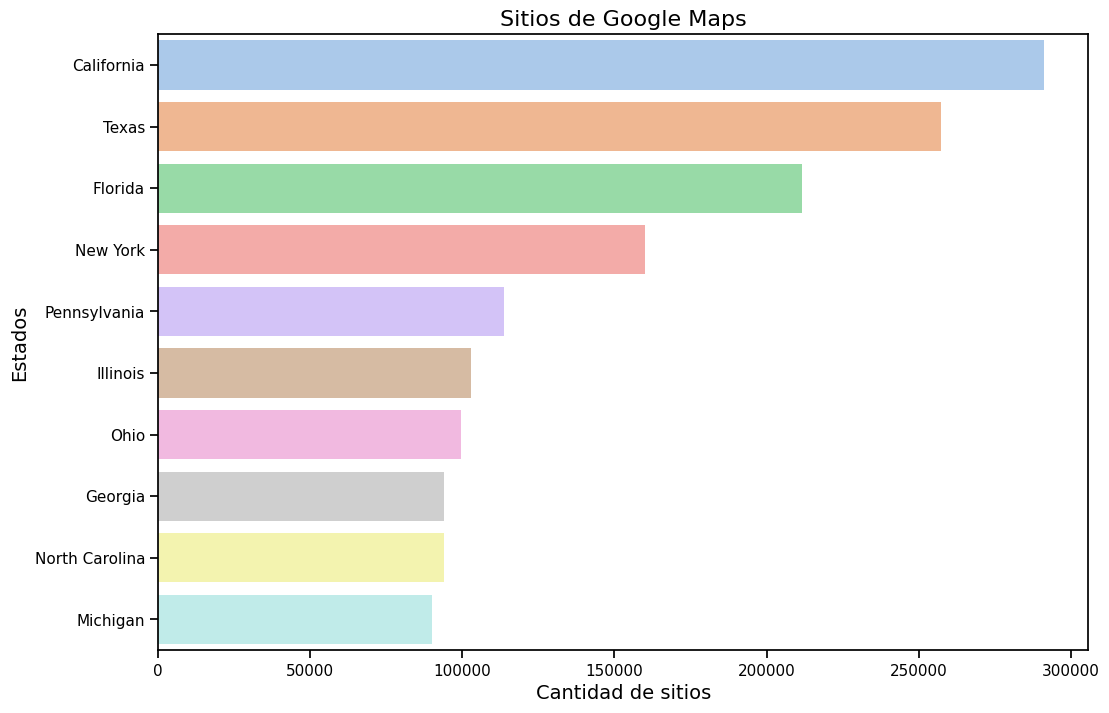

In [198]:
# Cuantós sitios corresponden a cada estado?
sitios_estado = metadata_sitios["state"].value_counts().head(10)

# Crear el gráfico de barras
plt.figure(figsize = (12, 8))
barplot = sns.barplot(x = sitios_estado.values, y = sitios_estado.index)

# Configurar el título y los ejes
plt.title('Sitios de Google Maps', fontsize = 16)
plt.xlabel('Cantidad de sitios', fontsize = 14)
plt.ylabel('Estados', fontsize = 14)

# Mostrar el gráfico
plt.show()

Vamos a analizar las categorías de los lugares, haciendo énfasis en los sitios de comida

In [167]:
# Crear un conjunto (set) con todas las etiquetas únicas
categorias_unicas = set()

# Iterar sobre la columna "category" y actualizar las categorías al conjunto
categorias = metadata_sitios["category"].dropna()
for lista_etiquetas in categorias:
    lista_etiquetas = ast.literal_eval(lista_etiquetas)
    if isinstance(lista_etiquetas, list):
        categorias_unicas.update(lista_etiquetas)

# Imprimir el número de etiquetas únicas
num_categorias = len(categorias_unicas)
print(f'Número de categorías: {num_categorias}')

# Imprimir las etiquetas únicas
print('Categorías únicas:', categorias_unicas)

Número de etiquetas únicas: 4471
Etiquetas únicas: {'Auto radiator repair service', 'Resident registration office', 'Truck farmer', 'Southern Italian restaurant', 'Wicker store', 'Festival hall', 'Photography service', 'Chocolate artisan', 'Breakfast restaurant', 'Outdoor bath', 'Federal reserve bank', 'Water companies', 'Recreational vehicle', 'Internet marketing service', 'Parking lot for motorcycles', 'Gas installation service', 'Room', 'Aikido school', 'Cabinet maker', 'Rare book store', 'Plant nursery', 'Custom label printer', 'Wholesaler', 'Organic', 'Chevrolet dealer', 'Toys', 'Bead store', 'Kosher restaurant', 'Display home centre', 'Income tax help association', 'Oxygen equipment supplier', 'Door warehouse', 'Kawasaki motorcycle dealer', 'Semi conductor supplier', 'GPS supplier', 'Cookie shop', 'Flamenco school', 'Discount supermarket', 'Housing authority', 'Parking Souterrain', 'Metal working shop', 'Reptile store', 'Shopping mall', 'Kitchens', 'Bagel shop', 'Hawaiian restaur

In [180]:
# Palabras clave relacionadas con restaurantes
palabras_clave_restaurante = ['restaurant', 'bar', 'cafe', 'diner', 'pub']
# Filtrar las categorías relacionadas con restaurantes
categorias_restaurantes = list()
for palabra_clave in palabras_clave_restaurante:
    for categoria in categorias_unicas:
        categoria_aux = categoria.split()
        for palabra in categoria_aux:
            if palabra_clave == palabra.lower():
                categorias_restaurantes.append(categoria)

In [182]:
# Tenemos la siguientes cantidad de categorías de lugares de comidas.
len(categorias_restaurantes)

338

In [194]:
# Función para verificar si la fila corresponde a un restaurante
def es_restaurante(categorias):
    categorias = ast.literal_eval(categorias)
    if isinstance(categorias, list):
        for categoria in categorias:
            if categoria in categorias_restaurantes:
                return True
                break
    return False

# Filtrar las filas donde la categoría está relacionada con restaurantes
metadata_sitios['es_restaurante'] = metadata_sitios['category'].apply(es_restaurante)

In [195]:
# Cantidad de sitios de comidas sobre el total
metadata_sitios["es_restaurante"].sum()

263868

In [202]:
# Filtrar solo los lugares que son restaurantes
restaurantes = metadata_sitios[metadata_sitios['es_restaurante']]

In [217]:
# Le borramos la columna "es_restaurante"
restaurantes = restaurantes.drop(columns = "es_restaurante")

De los casi 3M de lugares que tenemos, poco menos del 10% son lugares de comida (263m). Vamos a ver la distribución según los estados

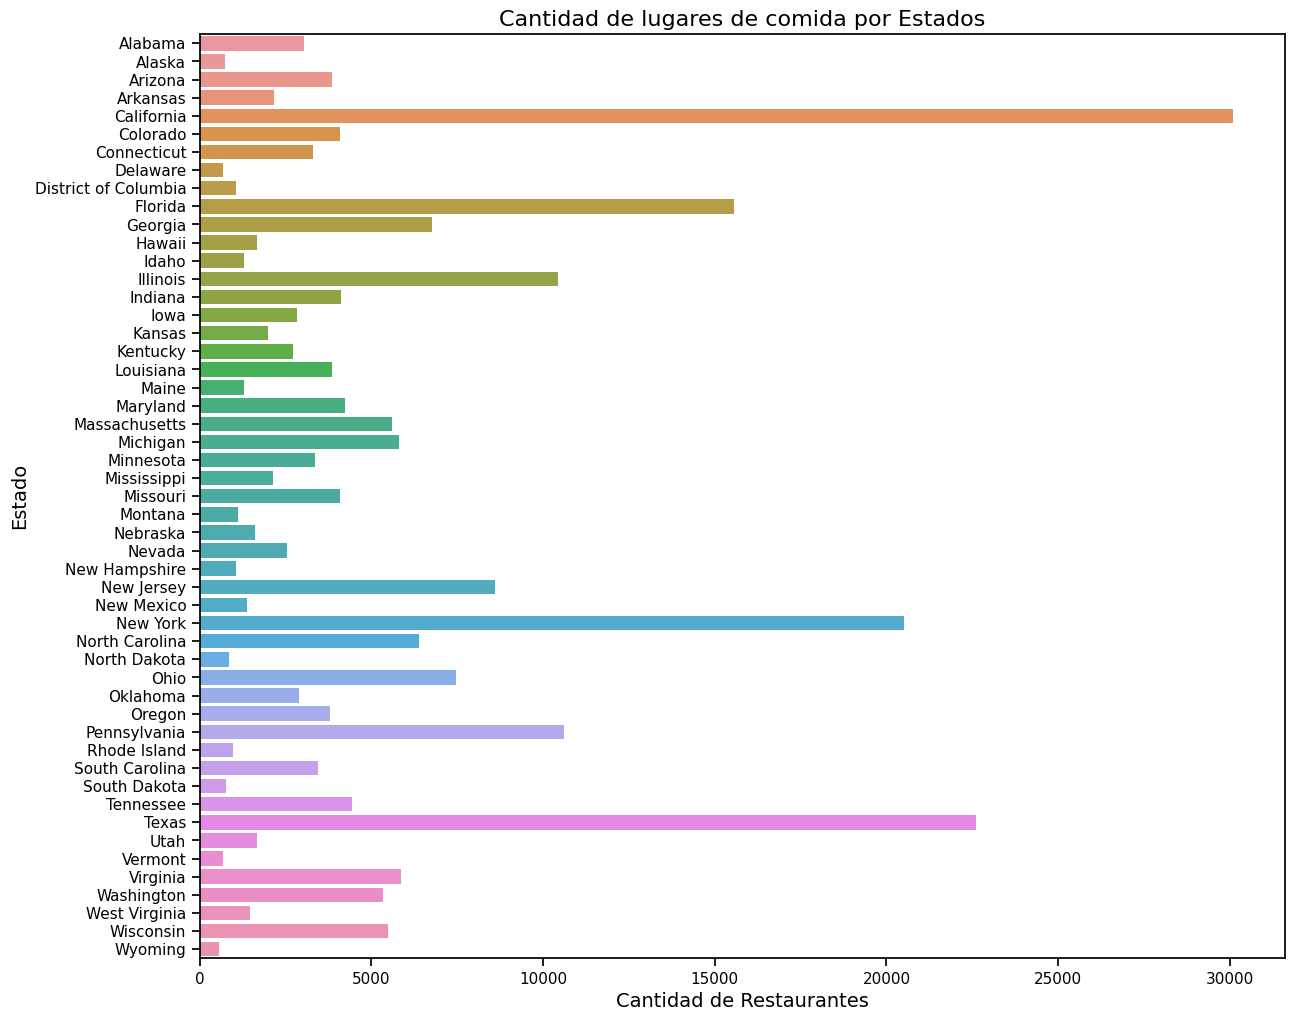

In [200]:
# Agrupar por estado y contar la cantidad de restaurantes en cada estado
restaurantes_por_estado = restaurantes.groupby('state').sum()

# Crear el gráfico de barras
plt.figure(figsize = (14, 12))
barplot = sns.barplot(x = restaurantes_por_estado.values, y = restaurantes_por_estado.index)

# Configurar el título y los ejes
plt.title('Cantidad de lugares de comida por Estados', fontsize = 16)
plt.xlabel('Cantidad de Restaurantes', fontsize = 14)
plt.ylabel('Estado', fontsize = 14)

# Mostrar el gráfico
plt.show()

Cuál es el puntaje medio de los lugares de comida en cada estado? Analizamos algún insight

In [209]:
restaurantes["avg_rating"] = restaurantes["avg_rating"].astype(float)

C:\Users\Mauricio Figueroa\AppData\Local\Temp\ipykernel_20444\2525253262.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restaurantes["avg_rating"] = restaurantes["avg_rating"].astype(float)


In [215]:
# Agrupar por estado y calcular el promedio de la columna "avg_rating"
rating_estado = restaurantes.groupby('state')['avg_rating'].mean().sort_values()

# 5 estados con las calificaciones más bajas
estados_calificaciones_bajas = rating_estado.head(5)

# 5 estados con las calificaciones más altas
estados_calificaciones_altas = rating_estado.tail(5)

# Mostrar los resultados
print("\nEstados con las calificaciones más bajas:")
print(estados_calificaciones_bajas)

print("\nEstados con las calificaciones más altas:")
print(estados_calificaciones_altas)


Estados con las calificaciones más bajas:
state
Maryland                4.042590
District of Columbia    4.071878
Arizona                 4.089297
Virginia                4.094850
Georgia                 4.105117
Name: avg_rating, dtype: float64

Estados con las calificaciones más altas:
state
Maine           4.297241
Idaho           4.298137
Montana         4.304545
South Dakota    4.318514
Oregon          4.335744
Name: avg_rating, dtype: float64


In [220]:
# Exportamos los datos
ruta_destino = "Datasets/Google Maps/metadata-sitios-clean"

# Exporta metadata_sitios a un archivo CSV
csv_path = os.path.join(ruta_destino, "metadata-sitios.csv")
metadata_sitios.to_csv(csv_path, index = False)

# Exporto restaurantes y las categorías
csv_path = os.path.join(ruta_destino, "restaurantes.csv")
restaurantes.to_csv(csv_path, index = False)

df_categorias_restaurantes = pd.DataFrame(categorias_restaurantes, columns = ['categorias_restaurantes'])
csv_path = os.path.join(ruta_destino, "categorias-restaurantes.csv")
df_categorias_restaurantes.to_csv(csv_path, index = False)